In [ ]:
import tensorflow as tf
tf.__version__
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Description

The dataset used for this project is the one published in the "[Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)" by Kaggle.


The data consists of 48x48 pixel grayscale images of faces.

The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The csv file given contains two main columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image.

The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.



## Data loading and splitting

This function will load the dataset using pandas. This will also split the dataset into training and testing subsets.

In [ ]:
PATH_TO_CSV_FILE = '/content/drive/MyDrive/fer2013.csv'

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np


def load_dataset(net=True):
    """Utility function to load the FER2013 dataset.

    It returns the formated tuples (X_train, y_train) , (X_test, y_test).

    Parameters
    ==========
    net : boolean
        This parameter is used to reshape the data from images in
        (cols, rows, channels) format. In case that it is False, a standard
        format (cols, rows) is used.
    """

    # Load and filter in Training/not Training data:
    global df
    df = pd.read_csv(PATH_TO_CSV_FILE)
    training = df.loc[df['Usage'] == 'Training']
    testing = df.loc[df['Usage'] != 'Training']

    # X_train values:
    X_train = training[['pixels']].values
    X_train = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_train]
    if net:
        X_train = [e.reshape((48, 48, 1)).astype('float32') for e in X_train]
    else:
        X_train = [e.reshape((48, 48)) for e in X_train]
    X_train = np.array(X_train)

    # X_test values:
    X_test = testing[['pixels']].values
    X_test = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_test]
    if net:
        X_test = [e.reshape((48, 48, 1)).astype('float32') for e in X_test]
    else:
        X_test = [e.reshape((48, 48)) for e in X_test]
    X_test = np.array(X_test)

    # y_train values:
    y_train = training[['emotion']].values
    y_train = keras.utils.to_categorical(y_train)

    # y_test values
    y_test = testing[['emotion']].values
    y_test = keras.utils.to_categorical(y_test)

    return (X_train, y_train) , (X_test, y_test)

(X_train, y_train) , (X_test, y_test) = load_dataset()

We can access the data and **plot some samples** to check out waht's inside:

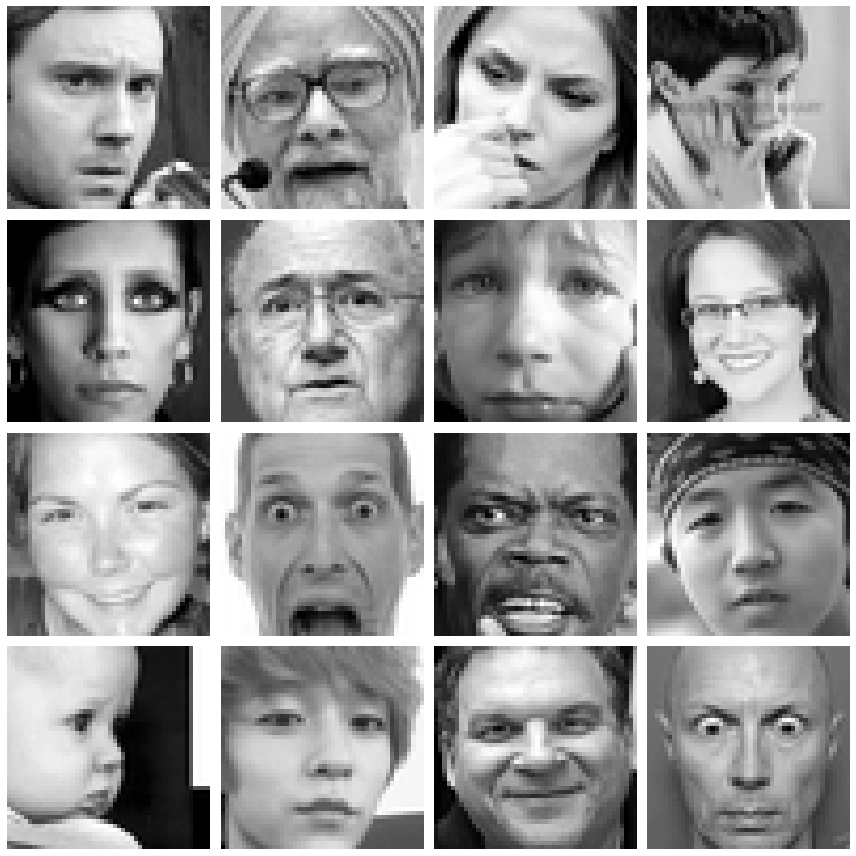

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i].reshape((48, 48)), cmap="gray")
    plt.axis('off')
    plt.tight_layout()

# Data Visualization

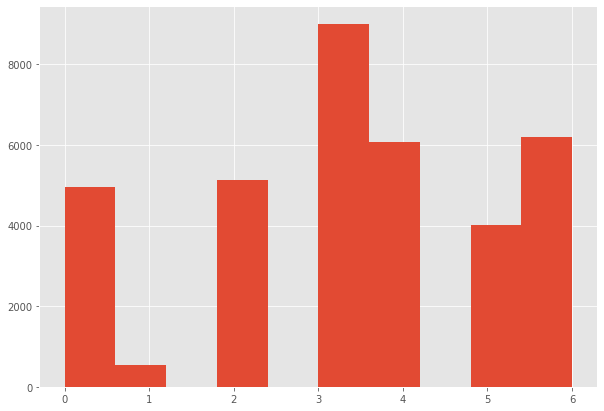

In [ ]:
#Viualization

# Creating histogram of emotions
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df["emotion"])
# Show plot
plt.show()

This shows how **data** is **imbalanced**

## Model architecture


I used the same model as: "[Extended deep neural network for facial emotion recognition (EDNN)](https://www.sciencedirect.com/science/article/abs/pii/S016786551930008X)" by Deepak Kumar Jaina, Pourya Shamsolmoalib, and Paramjit Sehdev (Elsevier – Pattern Recognition Letters 2019).

In their paper, they assure through some tests that their EDNN gives better results in classification tasks for Facial Expression Recognition, and by the architecture metrics this network turns out to be a more lightweight model compared with others.


The implementation will come from two functions:
- One to build the Residual Block
- The second one to build the rest of the model

The residual block architecture is as follows:

<center>
    <img src="https://raw.githubusercontent.com/RodolfoFerro/PyConCo20/full-code/media/residual_block.png" width="25%">
</center>


**Loss function:** categorical_crossentropy

**optimizer:** stochastic gradient descent (SGD)

We can now proceed to build our model:

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD


def ResidualBlock(prev_layer):
    """Residual block from the EDNN model for FER by Deepak Kumar Jaina,
    Pourya Shamsolmoalib & Paramjit Sehdev, as it appears in "Extended
    deep neural network for facial emotion recognition", 2019.
    """
    conv_1 = Conv2D(64, (1, 1))(prev_layer)
    conv_2 = Conv2D(64, (3, 3), padding="same")(conv_1)
    shortc = concatenate([conv_1, conv_2], axis=-1)
    conv_3 = Conv2D(128, (3, 3), padding="same")(shortc)
    conv_4 = Conv2D(256, (1, 1))(conv_3)
    output = concatenate([conv_4, prev_layer], axis=-1)

    return output


def EDNN(n_classes=7):
    """
    EDNN model for FER by Deepak Kumar Jaina, Pourya Shamsolmoalib &
    Paramjit Sehdev, as it appears in "Extended deep neural network for
    facial emotion recognition", 2019.
    """

    x = Input(shape=(48, 48, 1))
    y = Conv2D(32, (5, 5), input_shape=(48, 48, 1), strides=(2, 2),
               data_format='channels_last')(x)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Conv2D(64, (3, 3), strides=(1, 1))(y)
    y = ResidualBlock(y)
    y = Conv2D(128, (3, 3), strides=(1, 1), padding="same")(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Conv2D(128, (3, 3), strides=(1, 1))(y)
    y = ResidualBlock(y)
    y = Conv2D(256, (3, 3), strides=(1, 1), padding="same")(y)
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Conv2D(512, (3, 3), strides=(1, 1), padding="same")(y)
    y = Flatten()(y)
    y = Dense(1024, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(512, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(n_classes, activation='softmax')(y)

    # Create model:
    model = Model(x, y)

    # Compile model:
    opt = SGD(lr=LRATE, momentum=0.9, decay=LRATE/EPOCHS)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return model

We now create an instance of our model and verify the details of the architecture:

In [ ]:
# Set hyperparameters:
EPOCHS = 30
BATCH = 64
LRATE = 0.001

# Instance model
ednn = EDNN()



**The following table shows the designed model details**

In [ ]:
print(ednn.summary())



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 22, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 11, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 64)     18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

**The following graph is the plotted model**

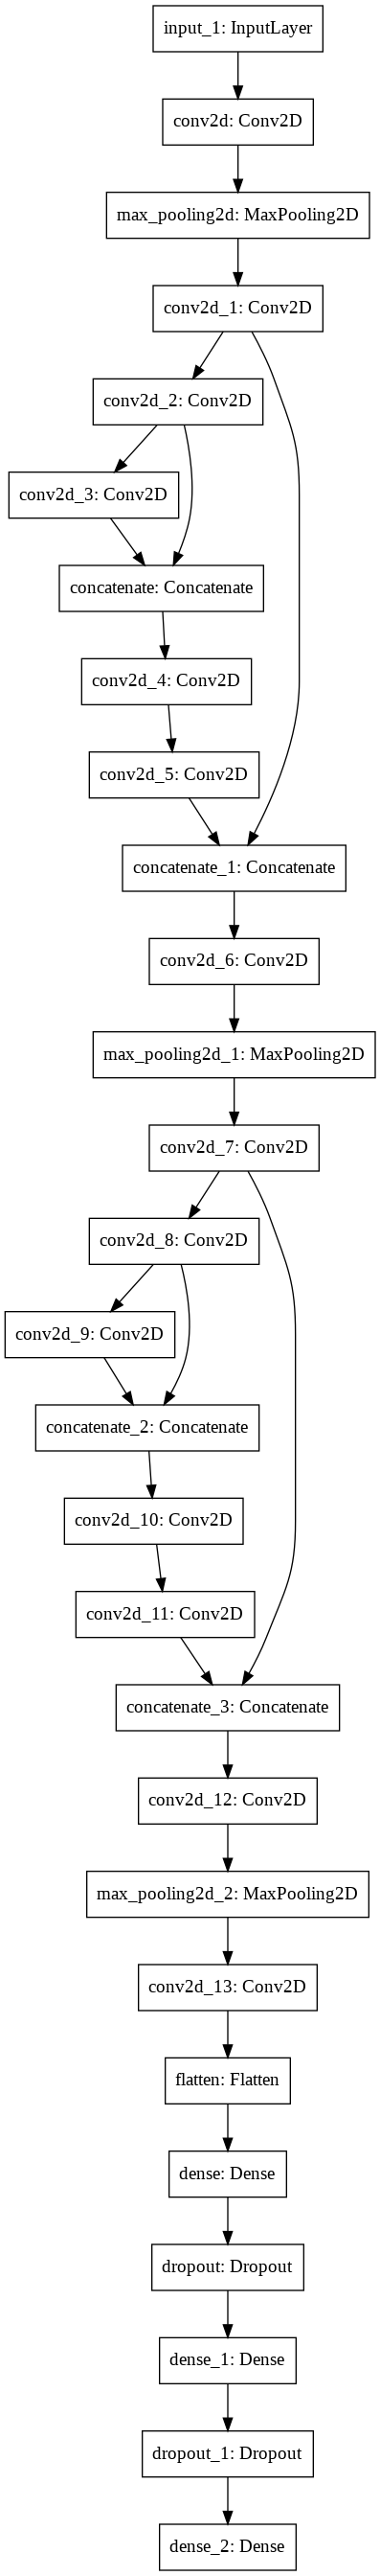

In [ ]:
tf.keras.utils.plot_model(ednn)

## Model training and evaluating (imbalanced data)
but first normalize the input images


In [ ]:
X_train /= 255 #normalize inputs between [0, 1]
X_test /= 255

history = ednn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH)

Epoch 1/30
449/449 [==============================] - 47s 36ms/step - loss: 1.8375 - accuracy: 0.2472 - val_loss: 1.8155 - val_accuracy: 0.2471
Epoch 2/30
449/449 [==============================] - 15s 33ms/step - loss: 1.8132 - accuracy: 0.2511 - val_loss: 1.8103 - val_accuracy: 0.2471
Epoch 3/30
449/449 [==============================] - 15s 33ms/step - loss: 1.8070 - accuracy: 0.2508 - val_loss: 1.8005 - val_accuracy: 0.2474
Epoch 4/30
449/449 [==============================] - 15s 33ms/step - loss: 1.7940 - accuracy: 0.2535 - val_loss: 1.7791 - val_accuracy: 0.2614
Epoch 5/30
449/449 [==============================] - 15s 33ms/step - loss: 1.7573 - accuracy: 0.2794 - val_loss: 1.7116 - val_accuracy: 0.3183
Epoch 6/30
449/449 [==============================] - 15s 33ms/step - loss: 1.6874 - accuracy: 0.3325 - val_loss: 1.6553 - val_accuracy: 0.3565
Epoch 7/30
449/449 [==============================] - 15s 33ms/step - loss: 1.6388 - accuracy: 0.3578 - val_loss: 1.6087 - val_accuracy:

*** Testing accuracy and loss***


computer and plot classification results and confusion matrix

In [ ]:
results = ednn.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)


113/113 [==============================] - 1s 13ms/step - loss: 1.5221 - accuracy: 0.5185
test loss, test acc: [1.522108554840088, 0.5185288190841675]


**Plot the results (accuracy and loss) of training and evaluation.**

In [ ]:
def plot_loss(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's training loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def plot_accuracy(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model's training accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

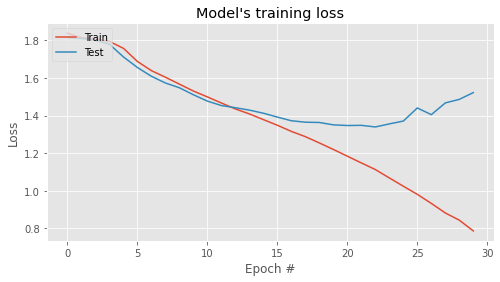

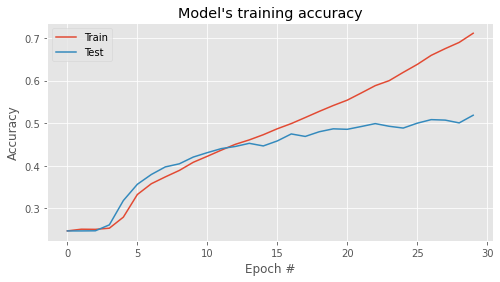

In [ ]:
# Plot loss:
plot_loss(history)
# plt.savefig('../media/loss.png', dpi=300)

# Plot accuracy:
plot_accuracy(history)
# plt.savefig('../media/accuracy.png', dpi=300)

A way to explore accuracy through classes is using a confusion matrix:

**Compute Confusion Matrix**

In [ ]:
# Create emotions map:
emotion_labels = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprise',
    'Neutral'
]

# Predict using trained model:
y_pred = ednn.predict(X_test)
y_pred = np.asarray([np.argmax(e) for e in y_pred])
y_true = np.asarray([np.argmax(e) for e in y_test])

[Text(58.5, 0.5, 'True label'), Text(0.5, 58.5, 'Predicted label')]

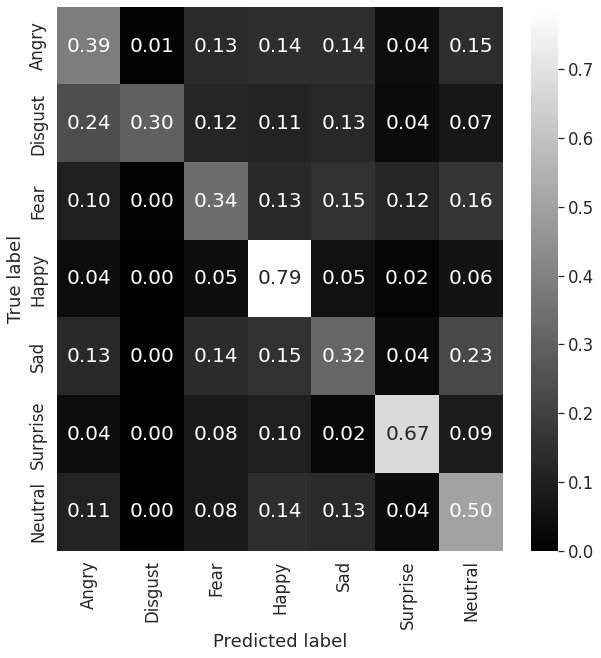

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Compute confusion matrix:
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False,
                 cmap='gray', yticklabels=emotion_labels,
                 xticklabels=emotion_labels, vmin=0,
                 vmax=np.max(cm_normalised), fmt=".2f",
                 annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

# Balancing, Resampling, and Re-Training and Re-Evaluating

One of the most common techniques when dealing with imbalanced datasets is resampling. In this case we could follow one of these approaches:

    Undersampling: removing samples from the majority class.
    Oversampling: adding samples to the minority class.
    Hiybrid: applying the two previous techniques.

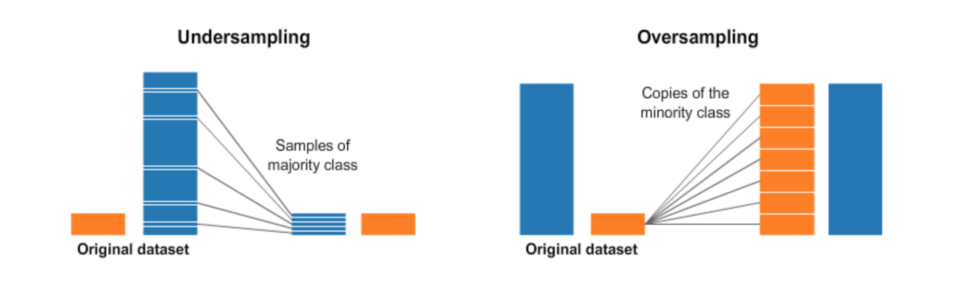

In [ ]:
import imblearn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Perform Random Over-Sampling and Random Under-Sampling**

In [ ]:
#load data to be resampled
training = df.loc[df['Usage'] == 'Training']
y_sample = training[['emotion']].values
X_sample = training[['pixels']].values


from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_sample, y_sample)


from imblearn.under_sampling import RandomUnderSampler
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_over, y_over)


X_train_resampled = X_under
y_train_resampled = y_under

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**We can spot the change in labels count from the following histograms (first plot is the data before resampling and the second is after resampling)**



**WE Can notice that:  The minority classes got more samples and the majority classes got less samples**


**We can see how classes became nearly balanced and each label has approximately same number of samples**

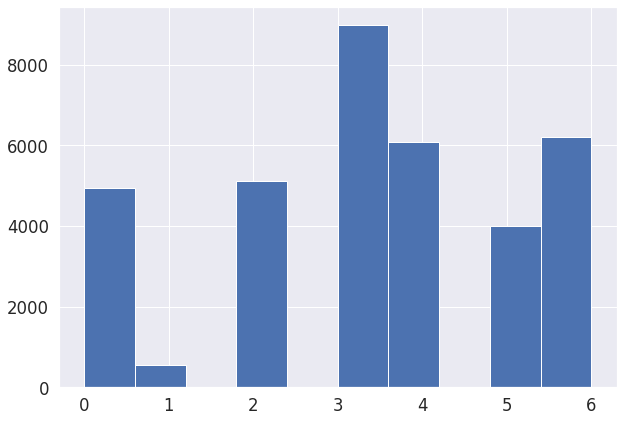

In [ ]:
#Viualization

# Creating histogram of emotions
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df["emotion"])
# Show plot
plt.show()

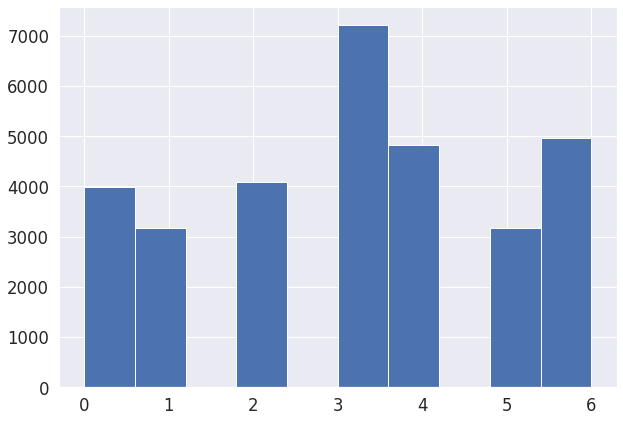

In [ ]:
#Viualization

# Creating histogram of emotions
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_train_resampled)
# Show plot
plt.show()

**We can see how classes became nearly balanced and each label has approximately same number of samples**

# traing and evaluate with the resampled data

In [ ]:
#reshape the resampled data

X_train_resampled = [np.fromstring(e[0], dtype=int, sep=' ') for e in X_train_resampled]
X_train_resampled = [e.reshape((48, 48, 1)).astype('float32') for e in X_train_resampled]

X_train_resampled = np.array(X_train_resampled)/255 #convert to numbers and normalize (/255)

y_train_resampled = keras.utils.to_categorical(y_train_resampled)

#history = ednn.fit(X_train_resampled, y_train_resampled, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH)

In [ ]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(31444, 48, 48, 1)
(31444, 7)


In [ ]:
ednn2 = EDNN()

history = ednn2.fit(X_train_resampled, y_train_resampled, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
492/492 [==============================] - 18s 35ms/step - loss: 1.9148 - accuracy: 0.2258 - val_loss: 1.8742 - val_accuracy: 0.2471
Epoch 2/30
492/492 [==============================] - 16s 33ms/step - loss: 1.9053 - accuracy: 0.2295 - val_loss: 1.8669 - val_accuracy: 0.2471
Epoch 3/30
492/492 [==============================] - 16s 33ms/step - loss: 1.8981 - accuracy: 0.2295 - val_loss: 1.8547 - val_accuracy: 0.2471
Epoch 4/30
492/492 [==============================] - 16s 33ms/step - loss: 1.8756 - accuracy: 0.2364 - val_loss: 1.7989 - val_accuracy: 0.2881
Epoch 5/30
492/492 [==============================] - 16s 33ms/step - loss: 1.8116 - accuracy: 0.2852 - val_loss: 1.7235 - val_accuracy: 0.3392
Epoch 6/30
492/492 [==============================] - 16s 33ms/step - loss: 1.7541 - accuracy: 0.3180 - val_loss: 1.6792 - val_accuracy: 0.3707
Epoch 7/30
492/492 [==============================] - 16s 33ms/step - loss: 1.7068 - accuracy: 0.3393 - val_loss: 1.6445 - val_accuracy:

In [ ]:
results = ednn.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)


113/113 [==============================] - 1s 12ms/step - loss: 1.5221 - accuracy: 0.5185
test loss, test acc: [1.522108554840088, 0.5185288190841675]


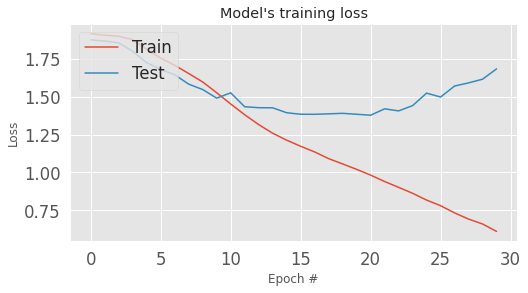

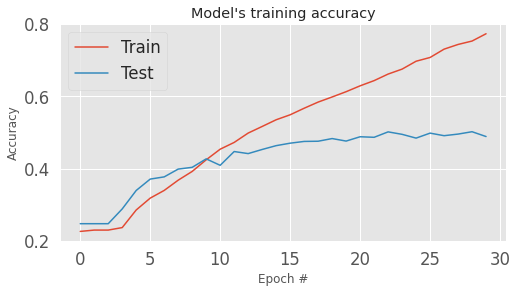

In [ ]:
# Plot loss:
plot_loss(history)

# Plot accuracy:
plot_accuracy(history)

**Create Confusion Matrix (for evaluation on the  resampled data)**

In [ ]:
# Create emotions map:
emotion_labels = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprise',
    'Neutral'
]

# Predict using trained model:
y_pred = ednn2.predict(X_test)
y_pred = np.asarray([np.argmax(e) for e in y_pred])
y_true = np.asarray([np.argmax(e) for e in y_test])



[Text(58.5, 0.5, 'True label'), Text(0.5, 58.5, 'Predicted label')]

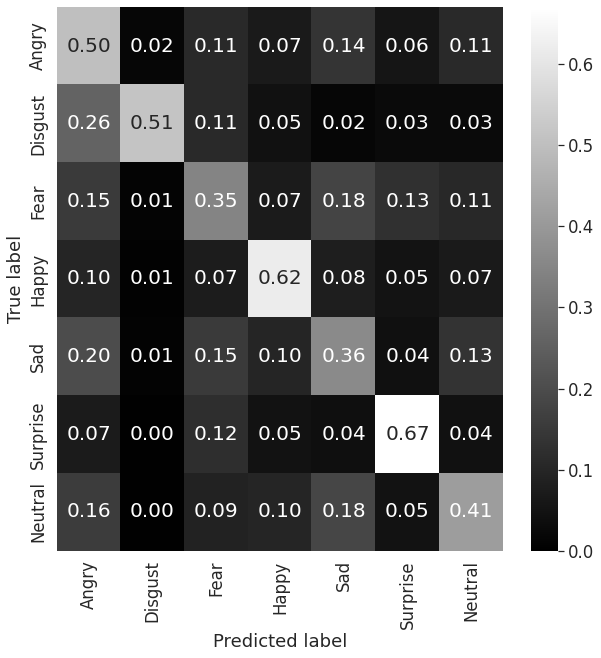

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Compute confusion matrix:
cm = confusion_matrix(y_true, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False,
                 cmap='gray', yticklabels=emotion_labels,
                 xticklabels=emotion_labels, vmin=0,
                 vmax=np.max(cm_normalised), fmt=".2f",
                 annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

We can notice that after resampling, the **accuracy didn't improve much**. However, the scores in the **confusion matrix** minority classes improved noticeably while declined for majority classes. The classification accuracy of each individual class became closer between different classes.